<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Statement-of-Project-Scope" data-toc-modified-id="Statement-of-Project-Scope-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Statement of Project Scope</a></span></li><li><span><a href="#General-Introduction" data-toc-modified-id="General-Introduction-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>General Introduction</a></span></li><li><span><a href="#Getting-the-Data" data-toc-modified-id="Getting-the-Data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Getting the Data</a></span><ul class="toc-item"><li><span><a href="#SRA-Toolkit-Setup" data-toc-modified-id="SRA-Toolkit-Setup-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>SRA Toolkit Setup</a></span></li><li><span><a href="#Downloading-the-First-10,000-Reads" data-toc-modified-id="Downloading-the-First-10,000-Reads-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Downloading the First 10,000 Reads</a></span></li><li><span><a href="#Importing-the-Reads" data-toc-modified-id="Importing-the-Reads-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Importing the Reads</a></span></li><li><span><a href="#About-the-FastQ-File-Format" data-toc-modified-id="About-the-FastQ-File-Format-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>About the FastQ File Format</a></span></li></ul></li><li><span><a href="#Quality-Control" data-toc-modified-id="Quality-Control-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Quality Control</a></span><ul class="toc-item"><li><span><a href="#Visualizing-Read-Statistics" data-toc-modified-id="Visualizing-Read-Statistics-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Visualizing Read Statistics</a></span></li><li><span><a href="#Resuming-Trimming" data-toc-modified-id="Resuming-Trimming-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Resuming Trimming</a></span></li><li><span><a href="#Running-a-full-pipeline" data-toc-modified-id="Running-a-full-pipeline-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Running a full pipeline</a></span></li><li><span><a href="#Aligning-Reads" data-toc-modified-id="Aligning-Reads-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Aligning Reads</a></span></li><li><span><a href="#Parsing-BBMap-Output" data-toc-modified-id="Parsing-BBMap-Output-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>Parsing BBMap Output</a></span></li><li><span><a href="#Confronting-Resource-Limitations" data-toc-modified-id="Confronting-Resource-Limitations-4.6"><span class="toc-item-num">4.6&nbsp;&nbsp;</span>Confronting Resource Limitations</a></span></li></ul></li></ul></div>

**Table of Contents**
<div id="toc"></div>

In [1]:
import Bio
import locale
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import platform
import shutil
import sys
import webbrowser
# Necessary to set font family for Latex in matplotlib:
from matplotlib import rc

locale.setlocale(locale.LC_ALL, '')
o_s = platform.system()
paths = {}

# to make this notebook's output stable across runs
np.random.seed(42)

if o_s == 'Darwin':
    paths['data_dir'] = '/Users/drew/data/Bio'
    paths['sra_tools_dir'] = '/Users/drew/Documents/Data/Bio/\
sratoolkit/bin'
    paths['fastqc'] = '/Applications/FastQC.app/Contents/MacOS/fastqc'
    paths['bbmap_dir'] = '/Users/drew/Documents/Data/Python/bbmap'
    
elif o_s == 'Windows':
    paths['data_dir'] = r'C:\Users\DMacKellar\Documents\Data\Bio\Bmap'
    paths['sra_tools_dir'] = r'C:\Users\DMacKellar\Documents\\
Python\BioPython\Galaxy_rnaseq\sratoolkit\sratoolkit.2.8.2-1-win64\bin'
    paths['fastqc_dir'] = r'C:\Users\DMacKellar\Documents\Python\BioPython\FastQC'
    paths['multiqc_dir'] = r'C:\Users\DMacKellar\Documents\Python\BioPython\MultiQC'
    paths['jdk_dir'] = r'C:\Program Files\Java\jdk1.8.0_101'
    paths['bzip_dir'] = r'C:\Users\DMacKellar\Documents\Python\BioPython\Glimmer\Glimmer-master\src\main\java'
    paths['bbmap_dir'] = r'C:\Users\DMacKellar\Documents\Python\BioPython\BBMap'
    paths['phi_x'] = r'C:/Users/DMacKellar/Documents/Python/BioPython/BBMap/resources/phix174_ill.ref.fa'
    paths['grch38_dir'] = os.path.join(paths['data_dir'], 'grch38')

# rc('font',**{'family':'serif','serif':['DejaVu Sans']})
rc('text', usetex=False)

for root, dirs, files in os.walk(paths['data_dir']):
    for file in files:
        file_under = str(file).replace('.', '_')
        path = os.path.join(root, file)
        paths[file_under] = path
        
sra_table = pd.read_csv(paths['Bmap_SraRunTable_txt'], sep='\t')

# Statement of Project Scope

The point of this notebook is to brush up on some basic Bioinformatics data-wrangling tasks.  I've sequenced a novel bacterial genome before, but in this case I thought I'd try aligning some RNAseq data, and thereby deriving tissue-specific gene expression patterns.

I've selected as an application aligning the commonly-used Illumina BodyMap RNAseq reads to the Human genome.  The raw reads for the Illumina BodyMap 2.0 project are [here](https://www.ncbi.nlm.nih.gov/sra?term=ERP000546&cmd=DetailsSearch).  There are 48 files, each with somewhere around 8E7 spots (potentially representing that many transcripts), for about 6-8E9 Bp per file.  A per-run listing can be found by clicking the above link and following the link at the top that says 'Send results to Run selector'.  I'll use a version of the data derived thereby below, to sort the data.

# General Introduction

RNA-seq alignment and quantification involves specific assumptions about methodology that are distinct from those of processing DNA reads for genome sequencing.

General info about the Illumina Body Map 2 is available from several sources.  One note on methodology from [this talk](https://personal.broadinstitute.org/mgarber/bodymap_schroth.pdf):

* The samples used for the 2X50 and 1X75 bp runs are prepared using the Illumina mRNA-Seq kit. 
    * These libraries are made from poly-A selected mRNA 
    * They are made with a random priming process and are not stranded (i.e., can represent either F or R direction)
    * The insert size for the PE libraries is about ~210 bps
        
16 Human tissues are represented in the project, and for each tissue they ran one whole lane of a HiSeq2000 sequencer, mixing the paired-end and 1x75 sequences.

As a side project, they pooled total RNA from each of the 16 tissues, then subjected the pooled RNAs to each of three different treatments:

* Total Poly-A selected mRNA
* Total Poly-A selected mRNA with Normalization
* Total RNA – no Poly-A Selection – to enrich for non-coding RNA
    * Complete Transcriptome Library Prep Method to capture all RNA species
    * Uses New Illumina protocol for reducing rRNA in whole transcriptome analysis

Apparently, the point of this latter approach was to validate a new protocol they had developed that was meant to enrich non-rRNA in a sample.  From each of these pooled runs they collected 1x100bp reads per sequence.

I find that the easiest way to parse the metadata associated with the project is to go to the SRA via the link provided above, go to the bottom of the first table in the right-hand panel, and, under the column 'Downloads', click the button 'RunInfo Table'.  Save the resulting file to a local path and open it with Pandas:

In [3]:
sra_table = pd.read_csv(paths['Bmap_SraRunTable_txt'], sep='\t')

sra_table.head()

,AvgSpotLen,BioSample,BioSourceProvider,Experiment,InsertSize,LibraryLayout,Library_Name,MBases,MBytes,Run,...,DATASTORE_filetype,DATASTORE_provider,Instrument,LibrarySelection,LibrarySource,LoadDate,Organism,Platform,ReleaseDate,SRA_Study
0,100,SAMEA962337,NaN,ERX011226,0,SINGLE,HCT20170,7290,4098,ERR030856,...,sra,ncbi,Illumina HiSeq 2000,cDNA,TRANSCRIPTOMIC,2014-05-30,Homo sapiens,ILLUMINA,2011-03-17,ERP000546
1,100,SAMEA962337,NaN,ERX011216,0,SINGLE,HCT20170,7461,4190,ERR030857,...,sra,ncbi,Illumina HiSeq 2000,cDNA,TRANSCRIPTOMIC,2014-05-30,Homo sapiens,ILLUMINA,2011-03-17,ERP000546
2,100,SAMEA962337,NaN,ERX011224,0,SINGLE,HCT20170,7365,4151,ERR030858,...,sra,ncbi,Illumina HiSeq 2000,cDNA,TRANSCRIPTOMIC,2014-05-30,Homo sapiens,ILLUMINA,2011-03-17,ERP000546
3,100,SAMEA962346,NaN,ERX011189,0,SINGLE,HCT20172,7274,4097,ERR030859,...,sra,ncbi,Illumina HiSeq 2000,cDNA,TRANSCRIPTOMIC,2014-05-30,Homo sapiens,ILLUMINA,2011-03-17,ERP000546
4,100,SAMEA962346,NaN,ERX011223,0,SINGLE,HCT20172,7241,4062,ERR030860,...,sra,ncbi,Illumina HiSeq 2000,cDNA,TRANSCRIPTOMIC,2014-05-30,Homo sapiens,ILLUMINA,2011-03-17,ERP000546


# Getting the Data

With the metadata in hand, we can select the reads of interest and prepare to download them programmatically by their accession number.  To interact with the SRA repository, however, NCBI requires that we download a special suite of software that they have written for this purpose; the reads don't appear to be available via any kind of structured URL query.

## SRA Toolkit Setup

Binaries are available for Linux, Mac OS X, and Windows.  Instructions are [here](https://trace.ncbi.nlm.nih.gov/Traces/sra/sra.cgi?view=toolkit_doc&f=std).  They can be downloaded and installed on some specified local directory, this location stored in a dict in Python, and called from within this notebook using the `subprocess` package.

Selecting the read files that interest you can be done by parsing the `sra_table` that I've downloaded above; the proper accession number for the SRA will be in the `Runs` column.

Then, you have to use the NCBI SRA Tools [fastq-dump](https://trace.ncbi.nlm.nih.gov/Traces/sra/sra.cgi?view=toolkit_doc&f=fastq-dump) program to get the FastQ (or FASTA) file from the raw image data that includes the flow cell the way the sequencer saw it.

The command-line syntax of the call to `fastq-dump` is of the general form:

    fastq-dump.exe -X 5 -Z SRR390728
    
in which the arg `-X 5` specifies that you only mean to download the first 5 reads (useful for ensuring the command works for you before you execute it in a large batch; obviously modify or omit this to suit your purposes).

Note: the default is to download paired reads from a single sequencing run as a single file, where the pairs are interleaved.  I find it more useful to download them as separate files, in which case the `'split-3'` arg should be passed to `fastq-dump`.

Once the general syntax is understood, proceed to download the runs as a batch using the `subprocess` package.  If you're unused to it, [`subprocess`](https://docs.python.org/3.6/library/subprocess.html) comes with significant functionality, but also complications of interface.  It will be useful to check our code by simply printing results below, before executing a full-fledged download:

In [72]:
if o_s == 'Windows':
    exe_ext = '.exe'
else:
    exe_ext = ''
paths['fastq_dump'] = os.path.join(paths['sra_tools_dir'], 
                                   'fastq-dump'+exe_ext)
paths['prefetch'] = os.path.join(paths['sra_tools_dir'], 
                                 'prefetch'+exe_ext)

In [7]:
import subprocess

os.chdir(paths['data_dir'])

commands1 = '{} -X 5 -Z SRR390728'.format(paths['fastq_dump'])
commands2 = '{} -X 10MB SRR390728'.format(paths['prefetch'])
commands3 = [paths['fastq_dump'], '-X', '5', '-Z', 'SRR390729']
commands4 = [paths['fastq_dump'], '-X', '5', '-Z', 'SRR390729']
subprocess.run(commands4, stdout=subprocess.PIPE, 
               stderr=subprocess.STDOUT, shell=False, check=False)

CompletedProcess(args=['/Users/drew/Documents/Data/Bio/sratoolkit/bin/fastq-dump', '-X', '5', '-Z', 'SRR390729'], returncode=0, stdout=b'Read 5 spots for SRR390729\nWritten 5 spots for SRR390729\n@SRR390729.1 1 length=100\nACCCTTCCCAACACCCTGGGAACCTATGGGGCCAGGCGTTCCTTACCAAAGCTCATGAGAAATACATCGAGCACAAAACTCTTCATCAGCTGGTTTTACT\n+SRR390729.1 1 length=100\n::::::::::::::::::::::::::::::44444///////////////::::::::::::::::::::::::::1:::44443///////////////\n@SRR390729.2 2 length=100\nGGATATTCGTATTCATCTTAGTGGATAAATACCACCTTACTTGGAAAATACTTCATCTGTAAAATAGAGGACTGCATGGTTCTGTGTATTTTAGAGAAGG\n+SRR390729.2 2 length=100\n::::::::::::::::::::::::::::::44444/////////--////:::::::::::::0::::::::::::::::44444///////////////\n@SRR390729.3 3 length=100\nAAACGCCAACAGAATGGTATTCAGTATGAATGAAAGAACTAAATTTTAACTTTGGTTGACTCATCTTTATAAGATGACCAGGCTAGAGAATCAGAGATCA\n+SRR390729.3 3 length=100\n::::::::::::::::::::::::::::::44444//////////////-::::::::::::::::::::::::::::::44443///////////-///\n@SRR390729.4 4 length=100\nTAG

That looks serviceable.  Now I'll wrap the general syntax into a function with more flexibility:

In [68]:
def sra_download(accession_list, *args, **kwargs):
    kwargs_new = []
    for k, v in kwargs.items():
        kwargs_new.append(k)
        kwargs_new.append(str(v))
    try:
        out_dir
    except NameError:
        pass
    else:
        if not os.path.isdir(out_dir):
            os.mkdir(out_dir)
        os.chdir(out_dir)
    print('Downloading {} files from the NCBI SRA server...'.format(
        len(accession_list)))
    for i, acc in enumerate(accession_list):
        cmds = [paths['fastq_dump'], *args, *kwargs_new, str(acc)]
        p = subprocess.Popen(cmds, stdout=subprocess.PIPE, 
                             stderr=subprocess.PIPE, shell=False)
        out, err = p.communicate()
        if len(err) > 0:
            print('\n{:>4} {} returned an error: \n{}\n'.format(
                i+1, acc, err.decode('ascii')))
        else:
            print('{:>4} {} downloaded'.format(i+1, acc))


In [15]:
os.chdir(os.path.join(paths['data_dir'], 'split3'))

In [9]:
args = ['--split-3']
kwargs = {'-X': '10000'}
acc1 = ['SRR390728']

sra_download(acc1, *args, **kwargs)

   1 SRR390728 downloaded


## Downloading the First 10,000 Reads

Ok, that's working.  Now, for the purposes of trying out additional steps in the pipeline, and keeping everything lightweight-enough to keep in local memory, I'll just download the first 10,000 spots associated with each of the tissues in the BodyMap dataset.

In [16]:
# %%time

# # DCM Note: After running this once locally, comment out
# # so we don't repeat the download whenever notebook is run

# args = ['--split-3']
# kwargs = {'-X': '10000'}
# accession_list = sra_table['Run']

# sra_download(accession_list, *args, **kwargs)

   1 ERR030858 downloaded
   2 ERR030859 downloaded
   3 ERR030860 downloaded
   4 ERR030861 downloaded
   5 ERR030862 downloaded
   6 ERR030863 downloaded
   7 ERR030864 downloaded
   8 ERR030865 downloaded
   9 ERR030866 downloaded
  10 ERR030867 downloaded
  11 ERR030868 downloaded
  12 ERR030869 downloaded
  13 ERR030870 downloaded
  14 ERR030871 downloaded
  15 ERR030872 downloaded

  16 ERR030873 returned an error: 
2018-06-16T05:20:31 fastq-dump.2.8.2 err: unknown while updating file within file system module - unknown system error 'No space left on device(28)'
2018-06-16T05:20:31 fastq-dump.2.8.2 int: unknown while updating file within file system module - cannot size local file to 4644011486 bytes
2018-06-16T05:20:31 fastq-dump.2.8.2 int: no error - skipping the cache-tee completely
2018-06-16T05:20:32 fastq-dump.2.8.2 err: unknown while updating file within file system module - unknown system error 'No space left on device(28)'
2018-06-16T05:20:32 fastq-dump.2.8.2 int: unknow


  26 ERR030883 returned an error: 
2018-06-16T05:22:27 fastq-dump.2.8.2 err: unknown while updating file within file system module - unknown system error 'No space left on device(28)'
2018-06-16T05:22:27 fastq-dump.2.8.2 int: unknown while updating file within file system module - cannot size local file to 3747076106 bytes
2018-06-16T05:22:27 fastq-dump.2.8.2 int: no error - skipping the cache-tee completely
2018-06-16T05:22:29 fastq-dump.2.8.2 err: unknown while updating file within file system module - unknown system error 'No space left on device(28)'
2018-06-16T05:22:29 fastq-dump.2.8.2 int: unknown while updating file within file system module - cannot size local file to 3747076106 bytes
2018-06-16T05:22:29 fastq-dump.2.8.2 int: no error - skipping the cache-tee completely



  27 ERR030884 returned an error: 
2018-06-16T05:22:37 fastq-dump.2.8.2 err: unknown while updating file within file system module - unknown system error 'No space left on device(28)'
2018-06-16T05:22:37 fas


  38 ERR030893 returned an error: 
2018-06-16T05:27:08 fastq-dump.2.8.2 err: unknown while updating file within file system module - unknown system error 'No space left on device(28)'
2018-06-16T05:27:08 fastq-dump.2.8.2 int: unknown while updating file within file system module - cannot size local file to 4451723433 bytes
2018-06-16T05:27:08 fastq-dump.2.8.2 int: no error - skipping the cache-tee completely
2018-06-16T05:27:10 fastq-dump.2.8.2 err: unknown while updating file within file system module - unknown system error 'No space left on device(28)'
2018-06-16T05:27:10 fastq-dump.2.8.2 int: unknown while updating file within file system module - cannot size local file to 4451723433 bytes
2018-06-16T05:27:10 fastq-dump.2.8.2 int: no error - skipping the cache-tee completely



  39 ERR030894 returned an error: 
2018-06-16T05:27:28 fastq-dump.2.8.2 err: unknown while updating file within file system module - unknown system error 'No space left on device(28)'
2018-06-16T05:27:28 fas

## Importing the Reads

Now that I've downloaded a sample of the data sets, let's split them into the relevant experimental condition: the single-end 75bp reads, the paired 50bp reads, and the single-end 100bp reads (this last, remember, comes from pooling the RNA from the various tissues, and is probably uninteresting for this analysis).  I'll write a function below to automatically name the variables that will hold the reads in local memory, automatically appending the relevant condition to the name based on the naming convention with which the reads were deposited in the SRA.  This will obviously vary based on the experiment, but I think it worthwhile to translate the arbitrary accession numbers into tissue-specific monikers when interpreting the data.

I'll import the tissue-specific paired- and single-end reads with [Biopython's SeqIO module](https://biopython.org/wiki/SeqIO).

In [3]:
from Bio import SeqIO

def bmap_reads_import(path=None):
    exps, reads = {}, {}
    bad = ['16 Tissues mixture', np.NaN]
    sra_tiss_df = sra_table[~sra_table.loc[:, 'organism_part'].isin(bad)]
    sra_tiss_df_s = sra_tiss_df.sort_values(by=['organism_part', 'LibraryLayout'])
    conv_dict = {'_s': '', '_f': '_1', '_r': '_2'}
    for _, row in sra_tiss_df_s.iterrows():
        if row['LibraryLayout'] == 'SINGLE':
            key = row['organism_part']+'_s'
            exps[key] = row['Run']
        else:
            exps[row['organism_part']+'_f'] = row['Run']
            exps[row['organism_part']+'_r'] = row['Run']
    for exp, run in exps.items():
        if exp not in reads.keys():
            f_name = run+conv_dict[exp[-2:]]+'.fastq'
            f_path = os.path.join(path, f_name)
            if os.path.isfile(f_path):
                with open(f_path, 'r') as f:
                    reads[exp] = SeqIO.to_dict(SeqIO.parse(f, 'fastq'))
            
    return reads
    

In [4]:
%%time

paths['split3'] = os.path.join(paths['data_dir'], 'split3')
bmap_reads = bmap_reads_import(path=paths['split3'])

Wall time: 15.7 s


In [5]:
# Let's just check one of the records
first_rec = bmap_reads['adipose_f']['ERR030880.1']
first_rec

SeqRecord(seq=Seq('CTGCTTGCAACTANAGCAACAGCCTTCATAGGCTATGNNCTCCCGAGAGG', SingleLetterAlphabet()), id='ERR030880.1', name='ERR030880.1', description='ERR030880.1 HWI-BRUNOP16X_0001:1:1:3016:1084#0 length=50', dbxrefs=[])

In [4]:
sra_table[sra_table['organism_part'] == 'adrenal']

,AvgSpotLen,BioSample,BioSourceProvider,Experiment,InsertSize,LibraryLayout,Library_Name,MBases,MBytes,Run,...,DATASTORE_filetype,DATASTORE_provider,Instrument,LibrarySelection,LibrarySource,LoadDate,Organism,Platform,ReleaseDate,SRA_Study
25,100,SAMEA962342,"Human adrenal total RNA, lot 0812003",ERX011217,248,PAIRED,HCT20159,7102,3494,ERR030881,...,sra,ncbi,Illumina HiSeq 2000,cDNA,TRANSCRIPTOMIC,2014-05-30,Homo sapiens,ILLUMINA,2011-03-17,ERP000546
33,75,SAMEA962342,"Human adrenal total RNA, lot 0812003",ERX011198,0,SINGLE,HCT20159,5448,4019,ERR030889,...,sra,ncbi,Illumina HiSeq 2000,cDNA,TRANSCRIPTOMIC,2014-05-30,Homo sapiens,ILLUMINA,2011-03-17,ERP000546


## About the FastQ File Format

It should be understood that the output above, by which BioPython parses the various data within the FastQ file, contains more than just the unique sequence name and the sequence data that are held in a FASTA file.  Most important is probably the 'quality' of each read, essentially the confidence of the sequencing machine & algorithm about the identity of that nucleotide at the time of sequencing.  But we'll review all of the parts of the file in its native format:

In the case of the example files downloaded from the site listed above, the first three reads in '`ERR030881_1.fastq`' are:

    @ERR030881.107 HWI-BRUNOP16X_0001:2:1:13663:1096#0/1
    ATCTTTTGTGGCTACAGTAAGTTCAATCTGAAGTCAAAACCAACCAATTT
    +
    5.544,444344555CC?CAEF@EEFFFFFFFFFFFFFFFFFEFFFEFFF
    @ERR030881.311 HWI-BRUNOP16X_0001:2:1:18330:1130#0/1
    TCCATACATAGGCCTCGGGGTGGGGGAGTCAGAAGCCCCCAGACCCTGTG
    +
    GFFFGFFBFCHHHHHHHHHHIHEEE@@@=GHGHHHHHHHHHHHHHHHHHH
    @ERR030881.1487 HWI-BRUNOP16X_0001:2:1:4144:1420#0/1
    GTATAACGCTAGACACAGCGGAGCTCGGGATTGGCTAAACTCCCATAGTA
    +
    55*'+&&5'55('''888:8FFFFFFFFFF4/1;/4./++FFFFF=5:E#

As can be seen, the reads are all cheek-to-jowl, with no lines separating them.  The eye is drawn to the whitespace of the lines that contain only '`+`', but that line doesn't come between different reads, but rather separates the lines containing base pair calls and their respective quality scores.  In fact, the line order goes:

* Unique Read Identifier; details on interpretation [available from Wikipedia](https://en.wikipedia.org/wiki/FASTQ_format#Illumina_sequence_identifiers).  The first few characters that are in common among all reads in the file are usually either designate the specific machine on which they were sequenced or, as here, are the string under which the data were registered on the [NCBI Sequence Read Archive](https://www.ncbi.nlm.nih.gov/sra).  Specifically, in this case, the page is [here](https://www.ncbi.nlm.nih.gov/sra/?term=ERR030881).

* Base Calls; I believe the only valid values are ['A', 'C', 'G', 'T', and 'N'].

* A spacer line containing '+'.  Despite appearance, it doesn't necessarily denote any kind of assumption about which strand of DNA in the chromosome from which the read originates; they're all supposed to be '+'.

* Quality scores; base quality scores can be interpreted with the info [here](http://www.drive5.com/usearch/manual/quality_score.html).  The encoding apparently differs between platform, however, so attention must be paid to what machine/technology generated the reads.

After those four lines, the next read comes immediately, with no separating line.

---

# Quality Control

It will be noted that the extremely powerful and cheap approach of Illumina's 2nd-gen tech to generate sequence data can output results whose quality varies greatly on the skill of the experimenter to generate the data.  The result is that you absolutely can't just dump all of the reads into a mapping protocol and expect much out.  Rather, as indicated above, individual bases within individual reads retain info about how believable they look, and we'll need to first summarize, and then delete some of the data, accordingly, to get this pipeline to run.

A very popular (and old) approach to quickly summarizing the quality data associated with any large FASTQ file of sequencing reads is [FASTQC](https://www.bioinformatics.babraham.ac.uk/projects/fastqc/).  I have tried writing a (pretty complicated) custom function in native Python to parse and visualize the output of the reads from BioPython, and it was a little more customized and pretty than FastQC, but it failed to deal with the variable-length reads output after trimming them; I think that, in this and many other steps of this pipeline, wrapping a fully-supported package that someone else has prepared is a more sensible approach.

FastQC is generally meant to be run in a GUI mode, outputting `.html` files that can be easily scanned through.  This will result in a workflow that automatically reads all sequences within and offers several tabs of summary data, and prints an icon beside the title of each tab that summarizes whether or not FastQC considers the output problematic for future integration into a mapping/assembly pipeline.  For a more programmatic interface, you have to dig a bit to find the proper syntax to call it from the command line.

Furthermore, even once FastQC has run, if you are summarizing all of the datasets in the BodyMap data, you'll have too many outputs to check.  While searching for a good wrapper/analysis tool for the FastQC data, I came upon another program called [MultiQC](http://multiqc.info/docs/).  It looks like it should be suitable for my purposes.  It runs fine on Mac and Linux, but in the process of attempting to get it to work on my PC, I ran into issues that led me to contact the developer.  It was interesting to run down the bugs, but I'll skip any comment on its operation here and get straight to showing the results of the QC.

I had wanted to be able to open the output of the QC steps within this notebook, but found that the formatting of the MultiQC tool's output HTML conflicts with native Jupyter functions, essentially breaking the notebook.  So I wrote the function below to open it in a separate tab.

## Visualizing Read Statistics

Ok, now it's time to check the reads' lengths, aggregate quality scores, and various other attributes.

In [25]:
def run_fastqc(trim_dir, *args, **kwargs):
    os.chdir(trim_dir)
    kwargs_new = []
    for k, v in kwargs.items():
        kwargs_new.append('{}={}'.format(k, v))
    files = []
    for file in os.listdir(trim_dir):
        path = os.path.abspath(file)
        _, extension = os.path.splitext(path)
        if extension in ['.fq', '.fastq']:
            files.append(path)
    if o_s == 'Darwin':
        fastqc = paths['fastqc']
        multiqc = 'multiqc .'
    if o_s == 'Windows':
        fastqc = 'java -cp {};{} \
uk.ac.babraham.FastQC.FastQCApplication'.format(paths['bzip_dir'], paths['fastqc_dir'])
        multiqc = 'python {} .'.format(os.path.join(*[paths['multiqc_dir'], 'scripts', 'multiqc']))
    cmds = [fastqc, *args, *kwargs_new, *files]
    final_cmds = ' '.join(cmds)

    p = subprocess.Popen(final_cmds, stdout=subprocess.PIPE, 
                         stderr=subprocess.PIPE, shell=True)
    out, err = p.communicate()
    if p.returncode != 0:
        print('\n returned an error: \n{}\n'.format(
            err.decode('ascii')))
    else:
        print('FastQC run')
    p = subprocess.Popen(multiqc, stdout=subprocess.PIPE, 
                         stderr=subprocess.PIPE, shell=True)
    out, err = p.communicate()
    if p.returncode != 0:
        print('\n returned an error: \n{}\n'.format(
            err.decode('ascii')))
    else:
        print('MultiQC run')
        report = os.path.join(trim_dir, 'multiqc_report.html')
        webbrowser.open(report)
    

In [26]:
run_fastqc(trim_dirs['1'])

FastQC run
MultiQC run


## Resuming Trimming

Now, to re-run [bbduk](https://jgi.doe.gov/data-and-tools/bbtools/bb-tools-user-guide/bbduk-guide/) with different trimming options.  The first file actually has pretty good quality per base scores out to about 30bp; but the second file (`ERR030872_2_t`) has mean scores below 20 up until base 11.  Further, the mean quality-per-read scores are unacceptably low for a large number of reads in both files.  This might not be too surprising, since the instructions I used for the first run were taken from a section entitled 'adapter trimming', and it didn't do much.  I think I'll need to perform different iterations in series, starting with getting a better trimming run.

It appears that it's not recognizing the adapters in the reference file.  The bbduk docs say that they include a more comprehensive list of Illumina adapters in their distro under `/bbmap/resources/adapters.fa`.  I'll point to that and try again.

After trying a few different configurations, it looks like a good mix for adapter trimming is to reduce the value of the integers passed to the `k` and `mink` parameters.  The bbduk docs had said that the value of `k` should 'be at most the length of the adapters', which I took to mean larger was better, but it's the kmer used to search the adapter sequences against your seq, so specifying a very long match might be too stringent.  Values of `k` and `mink` around `12` and `3`, respectively, seem to reduce most of the overrepresentation of ACTG in the first dozen bases of both reads.

Using the adapters file provided with bbmap causes more reads to be removed than with the custom file I made (with k=12 & mink=3, the % of bases removed is 21% as opposed to 7.5%, respectively.  Alternatively, increasing the hamming distance from `1` to `2` improves 5' variability, trimming ~16% of base info.

In [28]:
paths['bbmap_adapt'] = os.path.join(*[paths['bbmap_dir'], 'resources', 'adapters.fa'])

os.chdir(paths['split3'])
kwargs1 = {'ref': paths['bbmap_adapt'],
#           'ref': paths['illum_seq_fasta'],
          'ktrim': 'l', 'k': 15, 'mink': 3,
          'hdist': 1}
kwargs2 = {'ref': paths['illum_seq_fasta'],
          'ktrim': 'l', 'k': 12, 'mink': 3,
          'hdist': 2}
args = ['tbo -Xmx4g']

# run_bbduk([thyroid_paired], *args, **kwargs1)
trim_dirs = run_bbduk([thyroid_paired], *args, **kwargs2)

run_fastqc(trim_dirs['1'])

Starting trimming run with args:
('tbo -Xmx4g',)
['ref=C:\\Users\\DMacKellar\\Documents\\Data\\Bio\\Bmap\\illum_seq.fasta', 'ktrim=l', 'k=12', 'mink=3', 'hdist=2']
...

   1 ['C:\\Users\\DMacKellar\\Documents\\Data\\Bio\\Bmap\\split3\\ERR030872_1.fastq', 'C:\\Users\\DMacKellar\\Documents\\Data\\Bio\\Bmap\\split3\\ERR030872_2.fastq'] returned an error: 
Executing jgi.BBDukF [tbo, -Xmx4g, ref=C:\Users\DMacKellar\Documents\Data\Bio\Bmap\illum_seq.fasta, ktrim=l, k=12, mink=3, hdist=2, in1=C:\Users\DMacKellar\Documents\Data\Bio\Bmap\split3\ERR030872_1.fastq, in2=C:\Users\DMacKellar\Documents\Data\Bio\Bmap\split3\ERR030872_2.fastq, out1=C:\Users\DMacKellar\Documents\Data\Bio\Bmap\split3\trim_2018-07-08T18_48_05\ERR030872_1_t.fastq, out2=C:\Users\DMacKellar\Documents\Data\Bio\Bmap\split3\trim_2018-07-08T18_48_05\ERR030872_2_t.fastq]
Version 38.07

maskMiddle was disabled because useShortKmers=true
0.073 seconds.
Initial:
Memory: max=1836m, total=124m, free=108m, used=16m

Added 46120 kmers; 

## Running a full pipeline

After reviewing the [bbduk docs](https://jgi.doe.gov/data-and-tools/bbtools/bb-tools-user-guide/bbduk-guide/) (also elaborated upon [here](https://jgi.doe.gov/data-and-tools/bbtools/bb-tools-user-guide/data-preprocessing/)), I see that the author(s) actually recommend a specific, explicit workflow:

* Adapter Trimming
* Quality Trimming
* Force Trimming
* Force-Trim Modulo
* Quality Filtering
* Kmer Filtering

And additional steps that I don't quite understand, but sound like they're of diminishing importance.  I'll try running the 7 steps above in succession using the default args and kwargs listed in the docs, and check the result.

---

Ok, after having run the entire pipeline with the default params, I see that it's too aggressive.  It reduces the input 10,000 reads down to about 5,500, most of which (~3,000) are 40bp for the forward file, and 35bp for the reverse file, but each file also has significant size spikes at every multiple of 5bp in length (30, 25, etc.).  Per sequence quality scores and mean scores per base are both high; the data that remain would perform very well, I think.  But I'd like to reduce the amount of loss, I think some of the reads/bases being discarded could have value.

According to the printed output below, it seems that the biggest losses are occurring at the steps of Quality trimming (ditches 32% of reads and 45% of the bases) and Force trimming (ditches 17% of reads and 31% of bases).  Losses at other steps are marginal.  Actually, the Quality trimming loss was partially because I hadn't used the default quality cutoff of 10 from the right side, but 15 from either side.  Also, with adapter trimming at the default values it's not really catching anything, which could be part of the problem with quality at later steps.  I'll return that step to the params above.

Actually, it looks like the first few bases are still too problematic, not in terms of quality scores necessarily, but in terms of variability in distribution of ATCG values.  It's a problem for the first 10 in the first file, but only the first 5 in the second.  I think I'll return the force trim left to 10, and add a length filtering step of 20 at the penultimate step.

This approach keeps only ~4800 reads per file, with lengths between 20 and 40bp (mostly on the higher side), but the output quality scores are excellent.  I may provide another variant of this workflow that's less aggressive, but this does look kind of like the best way to recover useable data from the thyroid reads.  I'll wrap this workflow into a function and scale up with more reads.

In [29]:
# Note: pass in fastq files as a list of lists; pairs together
def run_bbduk_pipeline(fastq_list, trim_dirs=None, use_defaults=True, 
                       args_dict=None, kwargs_dict=None, 
                       keep_intermediate_files=False):
    def return_default_dicts():
        default_kwargs = {'adapter_trimming': {'ref':paths['illum_seq_fasta'], 
                                           'ktrim':'l', 'k':'15', 
                                           'mink':'4', 'hdist':'1'},
                          'quality_trimming': {'qtrim':'rl', 'trimq':'10'},
                          'force_trimming': {'ftl':'10', 'ftr':'139'},
                          'force-trim_modulo':{'ftm':'5'},
                          'quality_filtering':{'maq':'10', 'minlen':'20'},
                          'kmer_filtering':{'ref':paths['phi_x'], 'k':'31', 
                                            'hdist':'1'}
                         }
        default_args = {}
        for k in default_kwargs.keys():
            default_args[k] = []
        return default_args, default_kwargs
    
    if trim_dirs==None:
        trim_dirs = {}
        new_dir = '1'
    else:
        new_dir = max([int(x) for x in trim_dirs.keys()]) + 1
    if o_s == 'Windows':
        bbduk = 'java -cp {}\current jgi.BBDukF'.format(paths['bbmap_dir'])
    elif o_s == 'Darwin':
        bbduk = paths['bbduk']
    else:
        print('Error setting operating system')
    try:
        out_dir
    except NameError:
        ts = datetime.datetime.now().replace(microsecond=0).timestamp()
        read_ts = datetime.datetime.fromtimestamp(ts).isoformat().replace(':', '_')
        out_dir = os.path.join(os.getcwd(), 'trim_{}'.format(read_ts))
        os.mkdir(out_dir)
    else:
        if not os.path.isdir(out_dir):
            os.mkdir(out_dir)
    trim_dirs[str(new_dir)] = str(out_dir)
    os.chdir(out_dir)
    
    if use_defaults:
        args, kwargs = return_default_dicts()
    if args_dict:
        for k, v in args_dict.items():
            for k2, v2 in v.items():
                args[k][k2] = v2
    if kwargs_dict:
        for k, v in kwargs_dict.items():
            for k2, v2 in v.items():
                kwargs[k][k2] = v2
    
    for k, v in kwargs.items():
        for k2, v2 in v.items():
            args[k].append('{}={}'.format(k2, v2))
    
    with open('trim_log.txt', 'w') as f:
        for k, v in args.items():
            f.write('{}: {}\n'.format(k, ' '.join(v)))
    print('Starting trimming run with args:\n')
    for k, v in args.items():
        print('{}: {}'.format(k, ' '.join(v)))
    print('\n\nRead files processed:')
    def get_next_step(arg_list):
        order_of_steps = {'format_conversion': 0, 'adapter_trimming': 1, 
                          'contaminant_filtering': 2, 'nextera_lmp_lib_split': 3,
                          'human_contam_removal': 4, 'quality_trimming': 5, 
                          'force_trimming': 6, 'force-trim_modulo': 7,
                          'quality_filtering': 8, 'kmer_filtering': 9,
                          'kmer_masking': 10, 'quality_recalib': 11, 
                          'deduplication': 12, 'normalization': 13}
        sorted_steps = sorted(arg_list, key=lambda x: order_of_steps[x])
        for step in sorted_steps:
            yield step
        
    for i, fq in enumerate(fastq_list):
        steps_run = []
        steps = get_next_step(args)
        if len(fq) > 1:
            fq_base = [os.path.splitext(os.path.basename(x))[0] for x in fq]
        else:
            fq_base = [os.path.splitext(os.path.basename(*fq))[0]]
        filepaths = [os.path.join(out_dir, x) for x in fq_base]
        for step in steps:
            if len(steps_run) == 0:
                in_suff = ''
                out_suff = '_{}'.format(step)
                for f1, f2 in zip(fq, fq_base):
                    shutil.copy2(f1, '{}.fastq'.format(os.path.join(out_dir, f2)))
            elif len(steps_run) == len(args)-1:
                in_suff = '_{}'.format(steps_run[-1])
                out_suff = '_t'
            else:
                in_suff = '_{}'.format(steps_run[-1])
                out_suff = '_{}'.format(step)
            infiles = ['{}{}'.format(x, in_suff) for x in filepaths]
            outfiles = ['{}{}'.format(x, out_suff) for x in filepaths]
            if len(fq) == 2:
                files = 'in1={0}.fastq in2={1}.fastq out1={2}.fastq out2={3}.fastq'.format(infiles[0], infiles[1], outfiles[0], outfiles[1])
            elif len(fq) == 1:
                files = 'in={0}.fastq out1={1}.fastq'.format(infiles[0], outfiles[0])
            else:
                print('I can\'t understand the input fastq_list; did you pass a nested list?')
            cmds = [bbduk, files, *args[step]]
            final_cmds = ' '.join(cmd for cmd in cmds)
    
            p = subprocess.Popen(final_cmds, stdout=subprocess.PIPE, 
                                 stderr=subprocess.PIPE, shell=True)
            out, err = p.communicate()
            if p.returncode == 0:
                steps_run.append(step)
            else:
                print('{} file: {} step returned error {}'.format(fq[0], step, err.decode('ascii')))
                break
        print(fq_base)
        if keep_intermediate_files == False:
            for f in filepaths:
                os.remove('{}.fastq'.format(f))
                for step in steps_run[:-1]:
                    os.remove('{}_{}.fastq'.format(f, step))
    return trim_dirs


In [30]:
os.chdir(paths['split3'])
trim_dirs = run_bbduk_pipeline([thyroid_paired], trim_dirs=trim_dirs)

Starting trimming run with args:

adapter_trimming: ref=C:\Users\DMacKellar\Documents\Data\Bio\Bmap\illum_seq.fasta ktrim=l k=15 mink=4 hdist=1
quality_trimming: qtrim=rl trimq=10
force_trimming: ftl=10 ftr=139
force-trim_modulo: ftm=5
quality_filtering: maq=10 minlen=20
kmer_filtering: ref=C:/Users/DMacKellar/Documents/Python/BioPython/BBMap/resources/phix174_ill.ref.fa k=31 hdist=1


Read files processed:
['ERR030872_1', 'ERR030872_2']


In [31]:
latest_dir = trim_dirs[str(max(list(int(x) for x in trim_dirs.keys())))]
run_fastqc(latest_dir)

FastQC run
MultiQC run


Ok, that seems like an extremely complicated function to run the bbduk steps in a modifiable way, but I've not got a pipeline that should work.  Let's apply it to all of the BodyMap read files.

In [33]:
def get_fastqs(input_dir):
    singlets = []
    pairs = []
    for file in os.listdir(input_dir):
        base = os.path.splitext(file)[0].rstrip('_t')
        ext = os.path.splitext(file)[1]
        if ext in ['.fq', '.fastq']:
            if base[-2:] in ['_1', '_2']:
                pairs.append(file)
            else:
                filepath = os.path.join(input_dir, file)
                singlets.append([filepath])
    pairs2 = sorted(pairs)
    paired = []
    for x, y in zip(pairs2[0::2], pairs2[1::2]):
        base_x = os.path.splitext(x)[0].rstrip('_t')[:-2]
        base_y = os.path.splitext(y)[0].rstrip('_t')[:-2]
        if base_x == base_y:
            filepath_x = os.path.join(input_dir, x)
            filepath_y = os.path.join(input_dir, y)
            paired.append([filepath_x, filepath_y])

    return singlets + paired


In [34]:
os.chdir(paths['split3'])
bmap_inputs = get_fastqs(paths['split3'])
trim_dirs = run_bbduk_pipeline(bmap_inputs, trim_dirs=trim_dirs)

Starting trimming run with args:

adapter_trimming: ref=C:\Users\DMacKellar\Documents\Data\Bio\Bmap\illum_seq.fasta ktrim=l k=15 mink=4 hdist=1
quality_trimming: qtrim=rl trimq=10
force_trimming: ftl=10 ftr=139
force-trim_modulo: ftm=5
quality_filtering: maq=10 minlen=20
kmer_filtering: ref=C:/Users/DMacKellar/Documents/Python/BioPython/BBMap/resources/phix174_ill.ref.fa k=31 hdist=1


Read files processed:
['ERR030856']
['ERR030857']
['ERR030858']
['ERR030859']
['ERR030860']
['ERR030861']
['ERR030862']
['ERR030863']
['ERR030864']
['ERR030865']
['ERR030866']
['ERR030867']
['ERR030868']
['ERR030869']
['ERR030870']
['ERR030871']
['ERR030888']
['ERR030889']
['ERR030890']
['ERR030891']
['ERR030892']
['ERR030893']
['ERR030894']
['ERR030895']
['ERR030896']
['ERR030897']
['ERR030898']
['ERR030899']
['ERR030900']
['ERR030901']
['ERR030902']
['ERR030903']
['ERR030872_1', 'ERR030872_2']
['ERR030873_1', 'ERR030873_2']
['ERR030874_1', 'ERR030874_2']
['ERR030875_1', 'ERR030875_2']
['ERR030876_1', '

In [35]:
latest_dir = trim_dirs[str(max(list(int(x) for x in trim_dirs.keys())))]
run_fastqc(latest_dir)

FastQC run
MultiQC run


Ok, that looks good.  After lots of wrangling, I'd say I'm ready to align.


## Aligning Reads

The [classic approach](https://usegalaxy.org/u/jeremy/p/galaxy-rna-seq-analysis-exercise) is to use TopHat and Cufflinks.  It [sounds like](https://www.biostars.org/p/266161/) some more recent choices are STAR and [BBMap](https://jgi.doe.gov/data-and-tools/bbtools/bb-tools-user-guide/bbmap-guide/).  Since I've already used BBDuk for trimming, I'll try the latter first.

One major question is whether to align against the human genome or some previously-compiled transcriptome.  It [sounds like](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-016-0881-8) the former approach will catch more of the reads and have lower duplication rates (i.e., places where a read may map multiple times).  It looks like, as of 20180629, the latest stable NCBI RefSeq build for the human genome is [GRCh38.p12](https://www.ncbi.nlm.nih.gov/assembly/GCF_000001405.38).  More generally, **the** definitive resource for maintaining and iteratively improving human genome assembly and annotation data is the [Genome Reference Consortium](https://www.ncbi.nlm.nih.gov/grc/human/data); the 'GRC' part means 'Genome Reference Consortium'.  That consortium currently only handles maintaining the standard genomes for 4 organisms, so the first letter after GRC indicates the organism: humans ('h'), zebrafish ('z'), mouse ('m'), and chicken ('g' for 'Gallus').  '38' means that (as of Nov. 2017) this is the 38th such release, and the '.p12' subscript means that this release has been 'patched' a dozen times, representing more minor revisions to the sequence since that version was released.  

Each such release contains multiple datasets; transcriptomes and genomes, both including sequence from the Human Genome Sequencing project that have successfully been assembled into super-assemblies that represent whole chromosomes, as well as a genome that includes additional large scaffolds that haven't been successfully assigned to a particular chromosome.  The summary data table shows that there are two main kinds of assembly within: the more succinct and the more complete.

The records are hosted in the Genbank database, and therefore outside the reach of the `sra_download` function that I defined earlier.  Instead, you could use NCBI's [Batch Entrez](https://www.ncbi.nlm.nih.gov/sites/batchentrez) website, but the programmatic solution is probably to use [BioPython's EFetch](http://biopython.org/DIST/docs/tutorial/Tutorial.html#htoc126).  Note that this generally requires an API key affiliated with an NCBI account.  Furthermore, while I thought that it would be best to use the full-featured genbank files for the reference genome (to retain annotation info), the [bbmap docs](https://jgi.doe.gov/data-and-tools/bbtools/bb-tools-user-guide/bbmap-guide/) state that they only accept fasta or fastq as inputs.

Finally, when it comes to setting up a BBMap run, the [seqanswers thread](http://seqanswers.com/forums/showpost.php?p=134546&postcount=9) has some useful advice.

In [36]:
paths['grch38'] = os.path.join(paths['data_dir'], 'GRCh38_p12_table.txt')
with open(paths['grch38'], 'r') as f:
    grch38 = pd.read_csv(f, header=62, sep='\t', encoding='utf-8')
print(grch38.shape)
grch38

(595, 10)


,# Sequence-Name,Sequence-Role,Assigned-Molecule,Assigned-Molecule-Location/Type,GenBank-Accn,Relationship,RefSeq-Accn,Assembly-Unit,Sequence-Length,UCSC-style-name
0,1,assembled-molecule,1,Chromosome,CM000663.2,=,NC_000001.11,Primary Assembly,248956422,chr1
1,2,assembled-molecule,2,Chromosome,CM000664.2,=,NC_000002.12,Primary Assembly,242193529,chr2
2,3,assembled-molecule,3,Chromosome,CM000665.2,=,NC_000003.12,Primary Assembly,198295559,chr3
3,4,assembled-molecule,4,Chromosome,CM000666.2,=,NC_000004.12,Primary Assembly,190214555,chr4
4,5,assembled-molecule,5,Chromosome,CM000667.2,=,NC_000005.10,Primary Assembly,181538259,chr5
5,6,assembled-molecule,6,Chromosome,CM000668.2,=,NC_000006.12,Primary Assembly,170805979,chr6
6,7,assembled-molecule,7,Chromosome,CM000669.2,=,NC_000007.14,Primary Assembly,159345973,chr7
7,8,assembled-molecule,8,Chromosome,CM000670.2,=,NC_000008.11,Primary Assembly,145138636,chr8
8,9,assembled-molecule,9,Chromosome,CM000671.2,=,NC_000009.12,Primary Assembly,138394717,chr9
9,10,assembled-molecule,10,Chromosome,CM000672.2,=,NC_000010.11,Primary Assembly,133797422,chr10


In [2]:
import json

paths['credentials_json'] = os.path.join(paths['data_dir'], 'credentials.json')
with open(paths['credentials_json'], 'r') as f:
    credentials = json.load(f)

In [38]:
human_chr = grch38['RefSeq-Accn'].loc[:23].tolist()
human_chr.append(grch38['RefSeq-Accn'].loc[593])
human_all = grch38['RefSeq-Accn'].tolist()

In [39]:
from Bio import Entrez

paths['grch38_dir'] = os.path.join(paths['data_dir'], 'grch38')
os.chdir(paths['grch38_dir'])
Entrez.email = credentials['ncbi']['email']
ncbi_api = credentials['ncbi']['api_key']

# sra_download(human_all)
def download_genbank(acc_list, email=Entrez.email, api_key=ncbi_api, 
                     db='nuccore', rettype='fasta', 
                     retmode='text', file_ext='.fasta'):
    for acc in acc_list:
        if not os.path.isfile(acc):
            # Downloading...
            net_handle = Entrez.efetch(db=db, id=acc, rettype=rettype, retmode=retmode)
            out_handle = open('{}{}'.format(acc, file_ext), "w")
            out_handle.write(net_handle.read())
            out_handle.close()
            net_handle.close()
            print("{} downloaded".format(acc))

In [40]:
# # Note: cell commented out after running once;
# # don't want to download all those data again

# download_genbank(human_chr)

Now, I'll need to concatenate these into one large Fasta file, since I believe bbmap requires a single file as reference for mapping, not a dir.

In [41]:
# %%time

# # Note: Comment out this cell after running once

# paths['grch38_dir'] = os.path.join(paths['data_dir'], 'grch38')
# filenames = []

# for f in os.listdir(paths['grch38_dir']):
#     filenames.append(os.path.join(paths['grch38_dir'], f))
# paths['concat'] = os.path.join(paths['grch38_dir'], 'hs.fasta')
# with open(paths['concat'], 'w') as outfile:
#     for fname in filenames:
#         with open(fname) as infile:
#             for line in infile:
#                 outfile.write(line)
#                 outfile.write('\n\n')

Note that the resulting file is very large: around 3.5GB.  By comparison to [a calculation](https://stackoverflow.com/a/8954593/8637821) of the total data content of the human genome, this is very large.  Anyways, let's try aligning!

In [42]:
bbmap_path = os.path.join(paths['bbmap_dir'], 'bbmap.sh')
bbmap_path1 = 'java -cp {}\current align2.BBMap'.format(paths['bbmap_dir'])
out_path = os.path.join(*[paths['split3'], 'bbmappings', 'manual'])
in_path = os.path.join(trim_dirs['3'], 'ERR030856_t.fastq')
ref_path = os.path.join(paths['grch38_dir'], 'hs.fasta')
ref_path1 = os.path.join(paths['grch38_dir'], 'NC_000024.10.fasta')
cmd = '{0} -Xmx4G in={1} out={2}.sam ref={3} maxindel=200k ambig=random intronlen=20 xstag=us'.format(bbmap_path1, in_path, out_path, ref_path1)
print(cmd)
cmd1 = '{0} -Xmx7G ref={1} usemodulo'.format(bbmap_path1, ref_path)
print(cmd1)

java -cp C:\Users\DMacKellar\Documents\Python\BioPython\BBMap\current align2.BBMap -Xmx4G in=C:\Users\DMacKellar\Documents\Data\Bio\Bmap\split3\trim_2018-07-08T18_48_43\ERR030856_t.fastq out=C:\Users\DMacKellar\Documents\Data\Bio\Bmap\split3\bbmappings\manual.sam ref=C:\Users\DMacKellar\Documents\Data\Bio\Bmap\grch38\NC_000024.10.fasta maxindel=200k ambig=random intronlen=20 xstag=us
java -cp C:\Users\DMacKellar\Documents\Python\BioPython\BBMap\current align2.BBMap -Xmx7G ref=C:\Users\DMacKellar\Documents\Data\Bio\Bmap\grch38\hs.fasta usemodulo


In [43]:
sra_table.head()
sra_table.loc[sra_table['Run'] == 'ERR030856', 'Sex']
sra_table[sra_table['Run'] == 'ERR030856']
# sra_table.columns

,AvgSpotLen,BioSample,BioSourceProvider,Experiment,InsertSize,LibraryLayout,Library_Name,MBases,MBytes,Run,...,DATASTORE_filetype,DATASTORE_provider,Instrument,LibrarySelection,LibrarySource,LoadDate,Organism,Platform,ReleaseDate,SRA_Study
0,100,SAMEA962337,NaN,ERX011226,0,SINGLE,HCT20170,7290,4098,ERR030856,...,sra,ncbi,Illumina HiSeq 2000,cDNA,TRANSCRIPTOMIC,2014-05-30,Homo sapiens,ILLUMINA,2011-03-17,ERP000546


Ok, what I'm learning is that my laptop lacks the RAM to build the index file for the whole human genome.  Instead, I'll have to run a scaled-down version of the mapping, using single chromosomes.  For instance, the index built fine with just `NC_000024.10` (the Y chromosome).  If desireable, it might be fine to loop through the different chromosome reference files for each read, but given this is mostly a proof-of-concept notebook, I think I'll be ok with just running the reads against a single chromosome.

Actually, the mapping is relatively fast, compared to the indexing operation, at least when dealing with a few thousand reads, so in such a case the more time-permissive operation would be to loop through the chromosomes first, and for each chromosome, align all of the reads to them.

I was stunned at first to run an example alignment of `ERR030856` against a reference chromosome, and get the following stats out:

```
   ------------------   Results   ------------------

Genome:                 1
Key Length:             13
Max Indel:              200000
Minimum Score Ratio:    0.56
Mapping Mode:           normal
Reads Used:             6508    (486300 bases)

Mapping:                4.974 seconds.
Reads/sec:              1308.52
kBases/sec:             97.78


Read 1 data:            pct reads       num reads       pct bases          num bases

mapped:                   4.1026%             267         3.2387%              15750
unambiguous:              1.7210%             112         1.7674%               8595
ambiguous:                2.3817%             155         1.4713%               7155
low-Q discards:           0.0000%               0         0.0000%                  0

perfect best site:        0.2151%              14         0.1141%                555
semiperfect site:         0.2151%              14         0.1141%                555

Match Rate:                   NA               NA        82.6490%              14009
Error Rate:              20.2238%             253        17.3451%               2940
Sub Rate:                19.9840%             250         9.9941%               1694
Del Rate:                 1.5987%              20         7.0796%               1200
Ins Rate:                 1.5987%              20         0.2714%                 46
N Rate:                   0.0799%               1         0.0059%                  1
Splice Rate:              0.3197%               4       (splices at least 20 bp)

Total time:             10.177 seconds.
```

4% of reads mapping successfully?  But then I realized that, of course you wouldn't expect that many reads to align to a single one of the 23 possible chromosomes.  Checking the sra_table, I find that those reads were one of the '16-tissue mixture's.

That brings up a good test of accuracy: check the ovaries and testes tissues mappings to the Y chromosome (and maybe one more, for comparison, like thyroid tissue).

In [44]:
bbmap_path = os.path.join(paths['bbmap_dir'], 'bbmap.sh')
bbmap_path1 = 'java -cp {}\current align2.BBMap'.format(paths['bbmap_dir'])
out_path = os.path.join(*[paths['split3'], 'bbmappings', 'manual'])
thyroid_path = os.path.join(trim_dirs['3'], 'ERR030903_t.fastq')
testes_path = os.path.join(trim_dirs['3'], 'ERR030902_t.fastq')
ovaries_path = os.path.join(trim_dirs['3'], 'ERR030901_t.fastq')
ref_path = os.path.join(paths['grch38_dir'], 'hs.fasta')
ref_path1 = os.path.join(paths['grch38_dir'], 'NC_000024.10.fasta')
cmd1 = '{0} -Xmx4G in={1} out={2}.sam ref={3} maxindel=200k ambig=random intronlen=20 xstag=us'.format(bbmap_path1, thyroid_path, out_path, ref_path1)
cmd2 = '{0} -Xmx4G in={1} out={2}.sam ref={3} maxindel=200k ambig=random intronlen=20 xstag=us'.format(bbmap_path1, testes_path, out_path, ref_path1)
cmd3 = '{0} -Xmx4G in={1} out={2}.sam ref={3} maxindel=200k ambig=random intronlen=20 xstag=us'.format(bbmap_path1, ovaries_path, out_path, ref_path1)
print('{}\n{}\n{}'.format(cmd1, cmd2, cmd3))
# cmd1 = '{0} -Xmx4G ref={1}'.format(bbmap_path1, ref_path1)
# print(cmd1)

java -cp C:\Users\DMacKellar\Documents\Python\BioPython\BBMap\current align2.BBMap -Xmx4G in=C:\Users\DMacKellar\Documents\Data\Bio\Bmap\split3\trim_2018-07-08T18_48_43\ERR030903_t.fastq out=C:\Users\DMacKellar\Documents\Data\Bio\Bmap\split3\bbmappings\manual.sam ref=C:\Users\DMacKellar\Documents\Data\Bio\Bmap\grch38\NC_000024.10.fasta maxindel=200k ambig=random intronlen=20 xstag=us
java -cp C:\Users\DMacKellar\Documents\Python\BioPython\BBMap\current align2.BBMap -Xmx4G in=C:\Users\DMacKellar\Documents\Data\Bio\Bmap\split3\trim_2018-07-08T18_48_43\ERR030902_t.fastq out=C:\Users\DMacKellar\Documents\Data\Bio\Bmap\split3\bbmappings\manual.sam ref=C:\Users\DMacKellar\Documents\Data\Bio\Bmap\grch38\NC_000024.10.fasta maxindel=200k ambig=random intronlen=20 xstag=us
java -cp C:\Users\DMacKellar\Documents\Python\BioPython\BBMap\current align2.BBMap -Xmx4G in=C:\Users\DMacKellar\Documents\Data\Bio\Bmap\split3\trim_2018-07-08T18_48_43\ERR030901_t.fastq out=C:\Users\DMacKellar\Documents\Data\

For Thyroid, that gives:

`
Read 1 data:            pct reads       num reads       pct bases          num bases

mapped:                   7.1513%             362         5.2927%              12225
`

For Testes, it's:

`
Read 1 data:            pct reads       num reads       pct bases          num bases

mapped:                   5.4195%             290         4.7333%              12620
`

And for Ovaries:

`
Read 1 data:            pct reads       num reads       pct bases          num bases

mapped:                   8.0251%             384         6.1409%              13495
`

Well, obviously that's surprising, and potentially problematic.  I'll have to check some references and see if there's any reason to expect that ovaries tissue RNA might map to the Y-chromosome.

Actually, another problem occurs with the idea of mapping to different chromosomes individually: reads might align to multiple sites, and it would be hard to catch.  If this happens when using the entire genome as the index, then at least you'll be aware of which reads do so, and rank the different sites as better or worse matches.  If you map the reads to individual chromosomes serially, then it might be hard to track which ones have already mapped elsewhere with a better score.

So probably the best approach to do here would be just to choose a single chromosome, map all the reads to that locally (to do some proof-of-principle in this notebook), then do a more comprehensive run on Galaxy, or some other server instance where I'll have more resources.  Let's just do Chr1.

...Actually, even Chr1 runs out of memory with `-Xmx7G`.  Let's try Chr20.

In [45]:
grch38

,# Sequence-Name,Sequence-Role,Assigned-Molecule,Assigned-Molecule-Location/Type,GenBank-Accn,Relationship,RefSeq-Accn,Assembly-Unit,Sequence-Length,UCSC-style-name
0,1,assembled-molecule,1,Chromosome,CM000663.2,=,NC_000001.11,Primary Assembly,248956422,chr1
1,2,assembled-molecule,2,Chromosome,CM000664.2,=,NC_000002.12,Primary Assembly,242193529,chr2
2,3,assembled-molecule,3,Chromosome,CM000665.2,=,NC_000003.12,Primary Assembly,198295559,chr3
3,4,assembled-molecule,4,Chromosome,CM000666.2,=,NC_000004.12,Primary Assembly,190214555,chr4
4,5,assembled-molecule,5,Chromosome,CM000667.2,=,NC_000005.10,Primary Assembly,181538259,chr5
5,6,assembled-molecule,6,Chromosome,CM000668.2,=,NC_000006.12,Primary Assembly,170805979,chr6
6,7,assembled-molecule,7,Chromosome,CM000669.2,=,NC_000007.14,Primary Assembly,159345973,chr7
7,8,assembled-molecule,8,Chromosome,CM000670.2,=,NC_000008.11,Primary Assembly,145138636,chr8
8,9,assembled-molecule,9,Chromosome,CM000671.2,=,NC_000009.12,Primary Assembly,138394717,chr9
9,10,assembled-molecule,10,Chromosome,CM000672.2,=,NC_000010.11,Primary Assembly,133797422,chr10


In [46]:
def run_bbmap(reads_dir, ref_file_path, map_dirs=None, use_defaults=True, get_stats=True, args_list=None, kwargs_dict=None):
    reads_files = get_fastqs(reads_dir)
    for files in reads_files:
        file_base = files[0].split(sep='_')[0]
        if len(files) == 2:
            file_str = 'in1={} in2={} rcs=f'.format(files[0], files[1])
        elif len(files) == 1:
            file_str = 'in={}'.format(files[0])
            
    if map_dirs==None:
        map_dirs = {}
        new_dir = '1'
    else:
        new_dir = max([int(x) for x in trim_dirs.keys()]) + 1
    try:
        out_dir
    except NameError:
        ts = datetime.datetime.now().replace(microsecond=0).timestamp()
        read_ts = datetime.datetime.fromtimestamp(ts).isoformat().replace(':', '_')
        out_dir = os.path.join(os.getcwd(), 'map_{}'.format(read_ts))
        os.mkdir(out_dir)
    else:
        if not os.path.isdir(out_dir):
            os.mkdir(out_dir)
    map_dirs[str(new_dir)] = str(out_dir)
    os.chdir(out_dir)
            
    if o_s == 'Windows':
        bbmap = 'java -cp {}\current align2.BBMap'.format(paths['bbmap_dir'])
    elif o_s == 'Darwin':
        bbmap = os.path.join(paths['bbmap_dir'], 'bbmap.sh')
    
    def return_defaults():
        default_kwargs = {'maxindel': '200k', 'ambig': 'random', 'intronlen': '20', 'xstag': 'us'}
        default_args = ['-Xmx7G']
        return default_args, default_kwargs

    reads = get_fastqs(reads_dir)
    
    ref_base = os.path.splitext(os.path.basename(ref_file_path))[0].replace('.', '_')
    print('Aligning to {}'.format(ref_base))
    for read in reads:
        if use_defaults==True:
            args, kwargs = return_defaults()
        else:
            args, kwargs = [], {}

        if args_list:
            # imperfect, but try to replace any arg matching first 3 chars
            for a1 in args_list:
                for a2 in args:
                    if a1[:3] == a2[:3]:
                        args.remove(a2)
                        args.append(a1)
        if kwargs_dict:
            for k, v in kwargs_dict.items():
                kwargs[k] = v
        args.append('ref={}'.format(ref_file_path))
        if len(read) == 2:
            base_name = [os.path.splitext(os.path.basename(x))[0].rstrip('_t') for x in read]
            files = 'in1={0} in2={1} out={2}_{3}_{4}.sam'.format(read[0], read[1], ref_base, base_name[0], base_name[1])
        elif len(read) == 1:
            base_name = [os.path.splitext(os.path.basename(*read))[0].rstrip('_t')]
            files = 'in={0} out={1}_{2}.sam'.format(read[0], ref_base, base_name[0])
        else:
            print('I can\'t understand the input fastq_list; did you pass a nested list?')
        if get_stats==True:
            for stat in ['covstats', 'covhist', 'bincov']:
                kwargs['{}'.format(stat)] = '{}_{}_{}.txt'.format(stat, ref_base, base_name[0])
            for k, v in kwargs.items():
                args.append('{}={}'.format(k, v))
        cmds = [bbmap, files, *args]
        final_cmds = ' '.join(cmd for cmd in cmds)
    
        p = subprocess.Popen(final_cmds, stdout=subprocess.PIPE, 
                             stderr=subprocess.PIPE, shell=True)
        out, err = p.communicate()
        if p.returncode == 0:
            print('{} mapped'.format(read))
        else:
            print('{} file returned error: {}'.format(read, err.decode('ascii')))
            break

    return map_dirs

In [47]:
%%time

os.chdir(paths['split3'])
map_dirs = run_bbmap(latest_dir, paths['NC_000020_11_fasta'])

Aligning to NC_000020_11
['C:\\Users\\DMacKellar\\Documents\\Data\\Bio\\Bmap\\split3\\trim_2018-07-08T18_48_43\\ERR030856_t.fastq'] mapped
['C:\\Users\\DMacKellar\\Documents\\Data\\Bio\\Bmap\\split3\\trim_2018-07-08T18_48_43\\ERR030857_t.fastq'] mapped
['C:\\Users\\DMacKellar\\Documents\\Data\\Bio\\Bmap\\split3\\trim_2018-07-08T18_48_43\\ERR030858_t.fastq'] mapped
['C:\\Users\\DMacKellar\\Documents\\Data\\Bio\\Bmap\\split3\\trim_2018-07-08T18_48_43\\ERR030859_t.fastq'] mapped
['C:\\Users\\DMacKellar\\Documents\\Data\\Bio\\Bmap\\split3\\trim_2018-07-08T18_48_43\\ERR030860_t.fastq'] mapped
['C:\\Users\\DMacKellar\\Documents\\Data\\Bio\\Bmap\\split3\\trim_2018-07-08T18_48_43\\ERR030861_t.fastq'] mapped
['C:\\Users\\DMacKellar\\Documents\\Data\\Bio\\Bmap\\split3\\trim_2018-07-08T18_48_43\\ERR030862_t.fastq'] mapped
['C:\\Users\\DMacKellar\\Documents\\Data\\Bio\\Bmap\\split3\\trim_2018-07-08T18_48_43\\ERR030863_t.fastq'] mapped
['C:\\Users\\DMacKellar\\Documents\\Data\\Bio\\Bmap\\split3\\tr

Ok, that takes a while to run, but does complete successfully.  I'll try MultiQC on the resulting dir to see whether it can wrap any of the stats files output by `bbmap`.

---

## Parsing BBMap Output

In [48]:
def run_multiqc(in_dir):
    if o_s == 'Darwin':
        multiqc = 'multiqc .'
    if o_s == 'Windows':
        multiqc = 'python {} .'.format(os.path.join(*[paths['multiqc_dir'], 'scripts', 'multiqc']))
    os.chdir(in_dir)
    p = subprocess.Popen(multiqc, stdout=subprocess.PIPE, 
                         stderr=subprocess.PIPE, shell=True)
    out, err = p.communicate()
    if p.returncode != 0:
        print('\n returned an error: \n{}\n'.format(
            err.decode('ascii')))
    else:
        print('MultiQC run')
        report = os.path.join(in_dir, 'multiqc_report.html')
        webbrowser.open(report)

In [49]:
paths['map_dir1'] = r'C:\Users\DMacKellar\Documents\Data\Bio\Bmap\split3\map_2018-07-02T20_43_53'

run_multiqc(paths['map_dir1'])

MultiQC run


Ok, MultiQC *does* recognize data in that dir, but the only report it summarizes is the coverage histogram.  That's a relatively succinct output; for `covstats_NC_000020_11_ERR030856.txt` it reads:

In [50]:
paths['example_covstats'] = os.path.join(
    paths['map_dir1'], 'covstats_NC_000020_11_ERR030856.txt'
)

with open(paths['example_covstats'], 'r') as f:
    ex_covstats_df = pd.read_csv(f, sep='\t')
    
ex_covstats_table = sra_table[sra_table['Run'] == 'ERR030856']
ex_covstats_tiss = ex_covstats_table['organism_part']
ex_covstats_len = ex_covstats_table['AvgSpotLen']
print('ERR030856 tissue:\n{}\n\nERR030856 read length:\n{}'.format(
    ex_covstats_tiss, ex_covstats_len)
     )
ex_covstats_df

ERR030856 tissue:
0    16 Tissues mixture
Name: organism_part, dtype: object

ERR030856 read length:
0    100
Name: AvgSpotLen, dtype: int64


,#ID,Avg_fold,Length,Ref_GC,Covered_percent,Covered_bases,Plus_reads,Minus_reads,Read_GC,Median_fold,Std_Dev
0,"NC_000020.11 Homo sapiens chromosome 20, GRCh3...",0.002,64444167,0.438,0.1904,122717,235,316,0.4428,0,0.05


In other words, for the 100bp reads run made with a mix of RNA from 16 tissues, using just the first 10,000 reads (trimmed down to ~5,000 reads), about 551 reads mapped to the 20th chromosome of the grch38 build of the *H. sapiens* genome, covering about 122,717bp of the 64,444,167bp in that chromosome, or about 0.19%.

That's the `covhist` output.  BBMap can also output a `bincov` stats file, which (according to [this wiki](https://wiki.gacrc.uga.edu/wiki/BBMap#Documentation)) instead breaks down the reference file into chunks of different bp-long locations along the chromosome, and tells how many reads mapped to that region, specifically.

In [51]:
paths['example_bincov'] = os.path.join(
    paths['map_dir1'], 'bincov_NC_000020_11_ERR030856.txt'
)

with open(paths['example_bincov'], 'r') as f:
    ex_bincov_df = pd.read_csv(f, sep='\t', header=2)

print(ex_bincov_df['Cov'].describe())
print(ex_bincov_df['Cov'].value_counts().sort_index())
ex_bincov_df.head()

count    64445.000000
mean         0.002023
std          0.039496
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.330000
Name: Cov, dtype: float64
0.00    63943
0.01       10
0.02       72
0.03       37
0.04       26
0.05       24
0.06       27
0.07       19
0.08       45
0.09       78
0.10        3
0.11        1
0.12        2
0.13        6
0.14        4
0.15        1
0.16        1
0.17        7
0.18        3
0.19        3
0.20        1
0.21        1
0.22        3
0.23        2
0.25        3
0.26        2
0.27        1
0.28        3
0.29        1
0.31        1
0.32        1
0.33        2
0.34        2
0.35        2
0.39        1
0.40        2
0.44        2
0.45        1
0.49        1
0.54        1
0.61        1
0.62        2
0.63        1
0.65        2
0.71        2
0.74        1
0.76        1
0.79        1
0.82        2
0.84        1
0.87        1
1.00       80
1.04        1
1.15        1
1.22        1
1.29        1
1.33        1


,#RefName,Cov,Pos,RunningPos
0,"NC_000020.11 Homo sapiens chromosome 20, GRCh3...",0.0,1000,0
1,"NC_000020.11 Homo sapiens chromosome 20, GRCh3...",0.0,2000,1000
2,"NC_000020.11 Homo sapiens chromosome 20, GRCh3...",0.0,3000,2000
3,"NC_000020.11 Homo sapiens chromosome 20, GRCh3...",0.0,4000,3000
4,"NC_000020.11 Homo sapiens chromosome 20, GRCh3...",0.0,5000,4000


In other words, this file shows every kb of Chr20, and tells how much coverage it saw (I'm guessing that, since most of the values are fractional, it's not saying whether *any* reads mapped within that region at all, but, rather, `Cov` is a measure of how many of the 1,000bp within that region are represented).

Ok, next is `covhist`, which looks like it shows pretty much the same info, but the other way around: it shows the number of bp in the whole chromosome that are covered 0, 1, 2, etc. times:

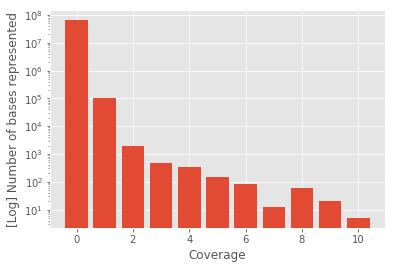

,#Coverage,numBases
0,0,64342285
1,1,98783
2,2,1965
3,3,476
4,4,326
5,5,152
6,6,81
7,7,12
8,8,61
9,9,21


In [52]:
paths['example_covhist'] = os.path.join(paths['map_dir1'], 'covhist_NC_000020_11_ERR030857.txt')

with open(paths['example_covhist'], 'r') as f:
    ex_covhist_df = pd.read_csv(f, sep='\t')

plt.bar(ex_covhist_df['#Coverage'], ex_covhist_df['numBases'])
plt.yscale('log')
plt.ylabel('[Log] Number of bases represented')
plt.xlabel('Coverage')
plt.show()
ex_covhist_df

There was also an option to output an additional stats file with the arg `basecov=basecov.txt`, but it was too big to keep (like, multiple gigabytes).  I'll try producing a single one here, though, and parsing its content):

In [53]:
os.chdir(trim_dirs['3'])
if not os.path.exists('dummy'):
    os.mkdir('dummy')
os.chdir('dummy')
shutil.copy2(os.path.join(trim_dirs['3'], 'ERR030856_t.fastq'), 'ERR030856_t.fastq')

kwargs_dict = {'basecov': 'basecov.txt'}
run_bbmap(os.getcwd(), paths['NC_000020_11_fasta'], kwargs_dict=kwargs_dict)

with open('basecov.txt', 'r') as f:
    head = [next(f) for x in range(10)]
    
os.chdir(trim_dirs['3'])
with open('example_basecov.txt', 'w') as f:
    for line in head:
        f.write(line)

shutil.rmtree('dummy')
for line in head:
    print(line)

Aligning to NC_000020_11
['C:\\Users\\DMacKellar\\Documents\\Data\\Bio\\Bmap\\split3\\trim_2018-07-08T18_48_43\\dummy\\ERR030856_t.fastq'] mapped
#RefName	Pos	Coverage

NC_000020.11 Homo sapiens chromosome 20, GRCh38.p12 Primary Assembly	0	0

NC_000020.11 Homo sapiens chromosome 20, GRCh38.p12 Primary Assembly	1	0

NC_000020.11 Homo sapiens chromosome 20, GRCh38.p12 Primary Assembly	2	0

NC_000020.11 Homo sapiens chromosome 20, GRCh38.p12 Primary Assembly	3	0

NC_000020.11 Homo sapiens chromosome 20, GRCh38.p12 Primary Assembly	4	0

NC_000020.11 Homo sapiens chromosome 20, GRCh38.p12 Primary Assembly	5	0

NC_000020.11 Homo sapiens chromosome 20, GRCh38.p12 Primary Assembly	6	0

NC_000020.11 Homo sapiens chromosome 20, GRCh38.p12 Primary Assembly	7	0

NC_000020.11 Homo sapiens chromosome 20, GRCh38.p12 Primary Assembly	8	0



Ok, so that `basecov.txt` file is 4.79GB in size; much larger than the input reference fasta.  And it appears that BBMap may attempt to generate one such file for *every* alignment made.  That would consume *way* too much space to be worth it.  But, to summarize the output, it looks essentially like the name describing the file.  Specifically, for *every* base in the reference chromosome, it lists the coverage from the reads, explicitly, in human-readable format (except of course for the fact that no human could feasibly have the patience to iteratively search through such an enormous number of lines to retrieve the coverage they want).  That info should be recoverable through some series of operations from the output `.sam` file itself, which is way more compact; there's no justification for keeping those stats output files from BBMap.

Finally, there's the sam file itself.  In looking for a viewer for that file format, I cam across a [thread](https://www.biostars.org/p/12752/) suggesting the use of software called `IGV`, from the [Broad Institute](http://software.broadinstitute.org/software/igv/AlignmentData).  Unfortunately, that program requires `bam` file format for input, which will require me to re-run bbmap:

In [54]:
os.chdir(trim_dirs['3'])
if not os.path.exists('dummy'):
    os.mkdir('dummy')
os.chdir('dummy')
shutil.copy2(os.path.join(trim_dirs['3'], 'ERR030856_t.fastq'), 'ERR030856_t.fastq')

kwargs_dict = {'out': 'ERR030856.bam'}
run_bbmap(os.getcwd(), paths['NC_000020_11_fasta'], kwargs_dict=kwargs_dict)

Aligning to NC_000020_11
['C:\\Users\\DMacKellar\\Documents\\Data\\Bio\\Bmap\\split3\\trim_2018-07-08T18_48_43\\dummy\\ERR030856_t.fastq'] mapped


{'1': 'C:\\Users\\DMacKellar\\Documents\\Data\\Bio\\Bmap\\split3\\trim_2018-07-08T18_48_43\\dummy\\map_2018-07-08T19_11_38'}

The outputs of the `BBMap` mapping are in SAM format, and in order to visualize them in the IGV viewer they must be converted to BAM and sorted.  The general suite of tools to do this is [Samtools](http://samtools.sourceforge.net/), which was written in C and which I had a lot of trouble compiling on Windows with various compilers.  So instead I defaulted to using the Windows 10 Ubuntu BASH support, which, when invoked, requires a slight alteration to the directory structure, in order to point to the files properly.

In [55]:
bash = 'bash'
samtools = '/mnt/c/Users/DMacKellar/Documents/Python/BioPython/samtools-1.8/samtools'
map_dir = '/mnt/c/Users/DMacKellar/Documents/Data/Bio/Bmap/split3/map2018-07-02T20_43_53'


In [56]:
def sort_sam(input_dir):
    os.chdir(input_dir)
    sam_files = []
    for file in os.listdir(input_dir):
        if os.path.splitext(file)[-1] == '.sam':
            sam_files.append(file)
            
    if o_s == 'Windows':
        samtools = '/mnt/c/Users/DMacKellar/Documents/Python/BioPython/samtools-1.8/samtools'
        sort_cmds = ['bash']
        index_cmds = ['bash']
        for sam in sam_files[::10]:
            # subprocess can't handle arbitrarily long cmd line strings
            fname = os.path.splitext(os.path.basename(sam))[0]
#             print(fname)
            sort_cmds.append('{0} sort {1} -o {2}.bam'.format(samtools, sam, fname))
            index_cmds.append('{0} index {2}.bam'.format(samtools, sam, fname))
        final_sort_cmds = ';'.join(sort_cmds)
        final_index_cmds = ';'.join(index_cmds)
        p1 = subprocess.Popen(final_sort_cmds, stdout=subprocess.PIPE, 
                         stderr=subprocess.PIPE, shell=True)
        out, err = p1.communicate()
        if p1.returncode != 0:
            print('\n returned an error: \n{}\n'.format(
                err.decode('ascii')))
        else:
            print('Sam files sorted.')
        p2 = subprocess.Popen(final_index_cmds, stdout=subprocess.PIPE, 
                         stderr=subprocess.PIPE, shell=True)
        out, err = p2.communicate()
        if p2.returncode != 0:
            print('\n returned an error: \n{}\n'.format(
                err.decode('ascii')))
        else:
            print('Bam files indexed.')
#         report = os.path.join(in_dir, 'multiqc_report.html')
#         webbrowser.open(report)

In [57]:
map_dir1 = r'C:\Users\DMacKellar\Documents\Data\Bio\Bmap\split3\map_2018-07-02T20_43_53'
sort_sam(map_dir1)

Sam files sorted.
Bam files indexed.


## Confronting Resource Limitations

That works, but the resulting view looks to be empty.  It turns out that 10,000 reads is going to output a very sparse map at the genomic level; typical RNAseq applications anticipate a lot higher coverage.  Zooming in to 75% of the max is the only way I can get to see anything in this first-pass, low-resolution run.

This brings up a fundamental problem with prototyping an RNAseq analysis pipeline on local hardware; the memory is too limited to achieve realistic results that would help guide the process going forward, when you anticipate running a full-scale experiment.  To resolve this, I've cast about for sources of more computational power, and hit upon the Bioinformatics resource named Galaxy, which claims to offer communal resources to users for free.  I've started to document my experience with that server, but, as this notebook is already getting significantly long, will store them in another Jupyter notebook.

**Note:** After a while of playing around with Galaxy, modifying my approach above to fit their BioBlend Python API, I'm finding that Galaxy also doesn't really offer something for nothing to the extent that I was hoping.  Their focus is primarily on standardizing and rendering more reproducible NGS analysis pipelines; they serve as a depot for workflows and a common syntax for using and distributing analytical approaches.  Their [storage capacity](https://galaxyproject.org/news/galaxy-public-servers-usage-quotas/) for a free account (on the 'Galaxy Main' server) is generous enough: around 200GB per round of analysis, but their memory allocation is [more limited](https://galaxyproject.org/main/#quotas).  They give you about 32GB of RAM to play with, which turns out to be enough to handle the preliminary steps of quality control on a single dataset from the Illumina BodyMap data (i.e., reads from a single tissue type), but it falls short when it comes to mapping to a reference transcriptome.

The alternative is to use their interface and general approach to wrap an instance of a cloud-based, fee-requiring service (like AWS), and I haven't tried that yet, but it will have to be my next stop.  For now, however, both my locally-supported AND Galaxy-based approaches to finishing this RNAseq pipeline turn out to have insufficient resources to carry out the mapping and quantification of the BodyMap datasets to the human genome.